# Import modules and Preporcessing

In [58]:
import pandas as pd
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

Load images

In [59]:
dataset_root_folder = './flowers'

x_image = []
y_label = []
img_size = (150, 150)

labels = os.listdir(dataset_root_folder)

for dirname in labels:
	filepath = os.path.join(dataset_root_folder, dirname)
	for file in os.listdir(filepath):
		filename = os.path.join(filepath, file)
		image = cv2.imread(filename)
		image = cv2.resize(image, img_size)
		# image = cv2.resize(image, (300,300))
		x_image.append(image)
		y_label.append(dirname)

### Extract color histogram features

In [60]:
def extract_color_histogram(images, bins=[6, 6, 6]):
    ls_hist = []

    for img in x_image:
        hist = cv2.calcHist([img], [0, 1, 2], None, bins, [0, 256, 0, 256, 0, 256])
        cv2.normalize(hist, hist)
        hist = hist.flatten()
        ls_hist.append(hist)
    return ls_hist

x_hist = extract_color_histogram(x_image)

### Split dataset into training, validation, and test

In [61]:
def train_val_test_split(x_hist, y_label, seed=321):
    # To keep track of shuffled data and their indices to refer to the image
    indexes_for_split = [x for x in range(len(x_hist))]
    _, test_label_indexes, ___, ____ = train_test_split(indexes_for_split, y_label, test_size=0.2, random_state=seed, shuffle=True, stratify=y_label)

    # Actual train test split of data
    x_train_val, x_test, y_train_val, y_test = train_test_split(x_hist, y_label, test_size=0.2, random_state=seed, shuffle=True, stratify=y_label)
    x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, test_size=0.25, random_state=seed, shuffle=True, stratify=y_train_val)
    return x_train, x_val, x_test, y_train, y_val, y_test, test_label_indexes

x_train, x_val, x_test, y_train, y_val, y_test, test_label_indexes = train_val_test_split(x_hist, y_label)

# KNN

In [62]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
import seaborn as sn
import time

Finding the right value of k

In [63]:
list_k = [x for x in range(1, 300)]
scores = []
for k in list_k:
    # print('k =', k)
    neigh = KNeighborsClassifier(n_neighbors=k)
    neigh.fit(x_train, y_train)
    scores.append(neigh.score(x_val, y_val))

Plot k and scores

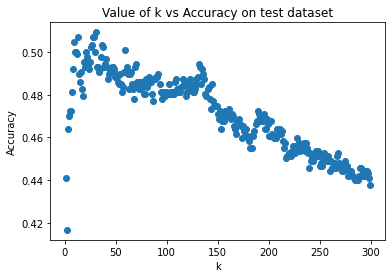

In [64]:
plt.scatter(list_k, scores)
plt.title("Value of k vs Accuracy on test dataset")
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.show()

Get the best value for k

In [65]:
index = scores.index(max(scores))
best_k = list_k[index]
print("Best k =", best_k, 'with an accuracy of', scores[index], 'on validation data')

Best k = 31 with an accuracy of 0.5092592592592593 on validation data


Build KNN with the best k value and use it on test dataset

In [66]:
neigh = KNeighborsClassifier(n_neighbors=best_k)
neigh.fit(x_train, y_train)

# Using test set
start_time = time.time()
score = neigh.score(x_test, y_test)
duration = time.time() - start_time

print("accuracy on test dataset =", score)
print("time taken to execute =", duration, 'seconds')

accuracy on test dataset = 0.49189814814814814
time taken to execute = 0.08403491973876953 seconds


Compare performance on test set depending on histogram of various sizes

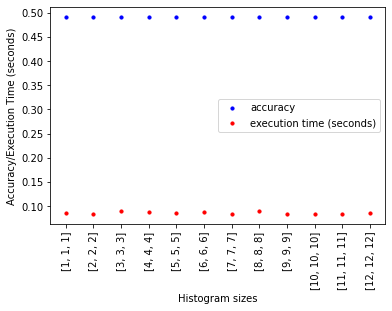

In [80]:
sizes = [x for x in range(1, 13)]
t_accuracies = []
t_seconds = []
for size in sizes:
    # Prepare input data
    test_x_hist = extract_color_histogram(x_image, bins=[size, size, size])
    # print(test_x_hist[0].shape)
    t_x_train, t_x_val, t_x_test, t_y_train, t_y_val, t_y_test, _ = train_val_test_split(x_hist, y_label)
    
    # Train the model
    test_neigh = KNeighborsClassifier(n_neighbors=best_k)
    test_neigh.fit(t_x_train, t_y_train)
    
    # Test the model
    start_time = time.time()
    t_score = neigh.score(t_x_test, t_y_test)
    duration = time.time() - start_time
    
    t_accuracies.append(t_score)
    t_seconds.append(duration)

# Graph result
fig = plt.figure()
ax1 = fig.add_subplot(111)
x_labels = [f'[{n}, {n}, {n}]' for n in sizes]

ax1.scatter(x_labels, t_accuracies, s=10, c='b', marker="o", label='accuracy')
ax1.scatter(x_labels, t_seconds, s=10, c='r', marker="o", label='execution time (seconds)')
plt.xlabel('Histogram sizes')
plt.ylabel('Accuracy/Execution Time (seconds)')
plt.xticks(rotation = 90)
# plt.legend(loc='upper left')
plt.legend()
plt.show()

Evaluate accuracy (using [6, 6, 6] histogram)

Text(33.0, 0.5, 'Truth')

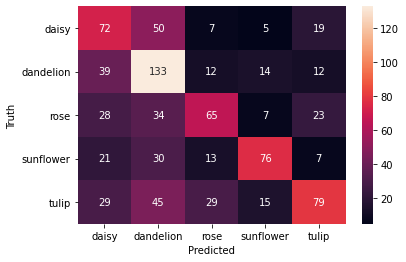

In [68]:
y_pred = neigh.predict(x_test)
cm_labels = np.unique(y_test)
cm = confusion_matrix(y_test, y_pred)

cm_array_df = pd.DataFrame(cm, index=cm_labels, columns=cm_labels)

sn.heatmap(cm_array_df, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

Examples of correctly classified flowers

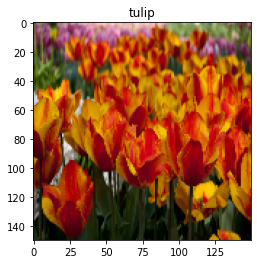

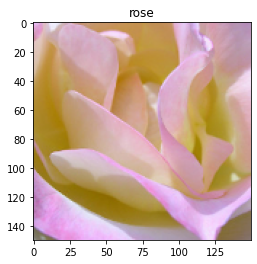

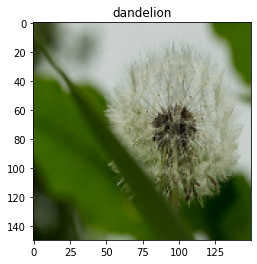

In [69]:
images_to_show = 3

# Find the indexes of the correctly classified flowers
indexes = []
for i, pred_flower in enumerate(y_pred):
        if pred_flower == y_test[i]:
            indexes.append(i)
            # Break out of loops if already found enough samples
            if len(indexes) >= images_to_show:
                break

for i in indexes:
    fig, ax1 = plt.subplots(1,1)
    ax1.set_title(y_test[i])
    ax1.imshow(cv2.cvtColor(x_image[test_label_indexes[i]], cv2.COLOR_BGR2RGB))
    plt.show()

Examples of wrongly classified flowers

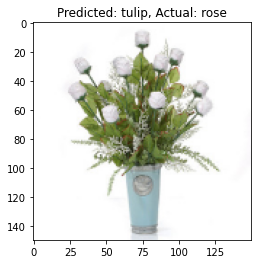

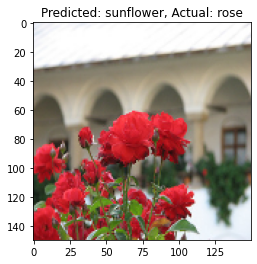

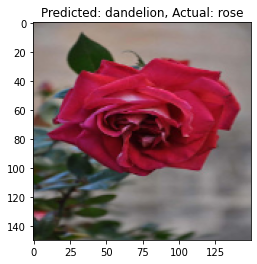

In [70]:
images_to_show = 3

# Find the indexes of the wrongly classified flowers
indexes = []
for i, pred_flower in enumerate(y_pred):
        if pred_flower != y_test[i]:
            indexes.append(i)
            # Break out of loops if already found enough samples
            if len(indexes) >= images_to_show:
                break

for i in indexes:
    fig, ax1 = plt.subplots(1,1)
    ax1.set_title(f'Predicted: {y_pred[i]}, Actual: {y_test[i]}')
    ax1.imshow(cv2.cvtColor(x_image[test_label_indexes[i]], cv2.COLOR_BGR2RGB))
    plt.show()